In [1]:
import numpy as np
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

sns.set(style="whitegrid")

In [2]:
n_samples = 500
n_features = 2
n_classes = 2
X = np.random.randn(n_samples, n_features) * 2
y = np.where(np.dot((X.T / np.linalg.norm(X, axis=1)).T, np.ones(n_features)/np.sqrt(n_features)) > np.cos(np.pi/8), 1, 0)

X_1 = X[y == 1]
X_0 = X[y == 0]
y_1 = y[y == 1]
y_0 = y[y == 0]

X_0 = X_0[::3]
y_0 = y_0[::3]

X = np.concatenate([X_1, X_0])
y = np.concatenate([y_1, y_0])

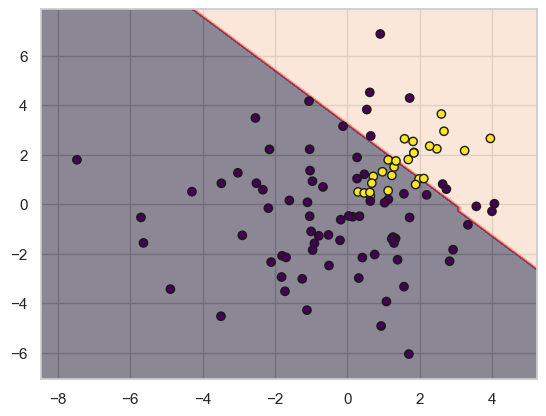

In [3]:
clf = SVC(kernel='linear')
clf.fit(X, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')

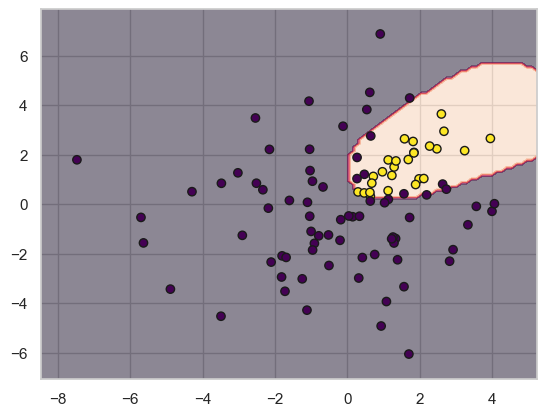

In [4]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')

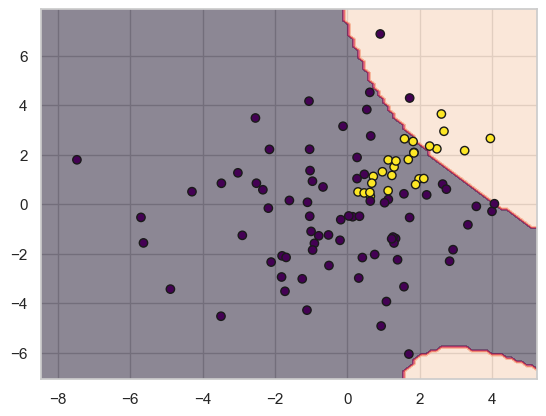

In [5]:
clf = SVC(kernel='poly')
clf.fit(X, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')

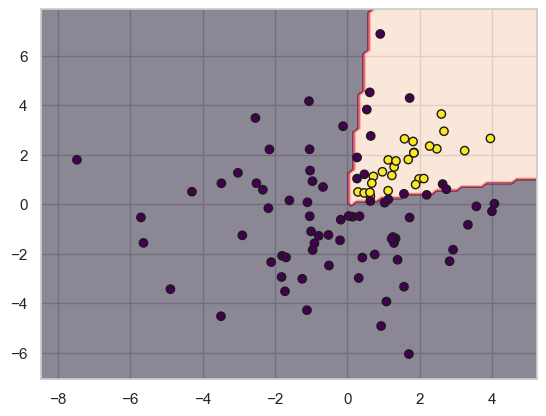

In [6]:
clf = SVC(kernel=cosine_similarity)
clf.fit(X, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')

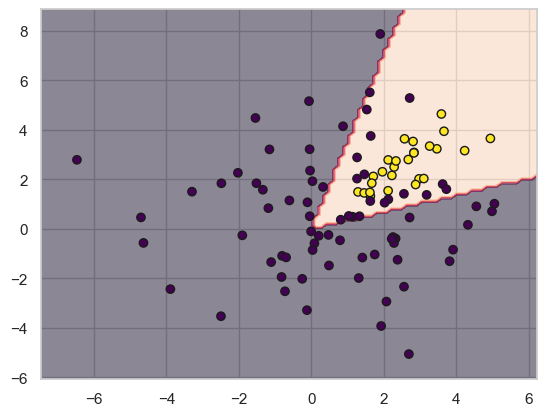

In [7]:
X_shifted = X + np.array([1, 1])

clf = SVC(kernel=cosine_similarity)
clf.fit(X_shifted, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X_shifted, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X_shifted[::2, 0], X_shifted[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')

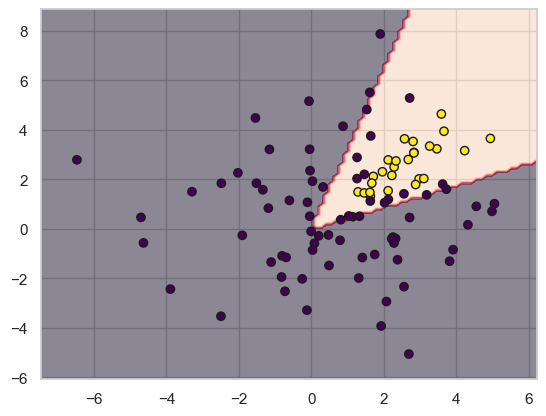

In [8]:
def cosine_rbf_kernel(X, Y=None, gamma=None):
    if Y is None:
        Y = X
    if gamma is None:
        gamma = 1 / X.shape[1]
    return np.exp(-gamma * 2 * (1 - cosine_similarity(X, Y)))

clf = SVC(kernel=cosine_rbf_kernel)
clf.fit(X_shifted, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X_shifted, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X_shifted[::2, 0], X_shifted[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')

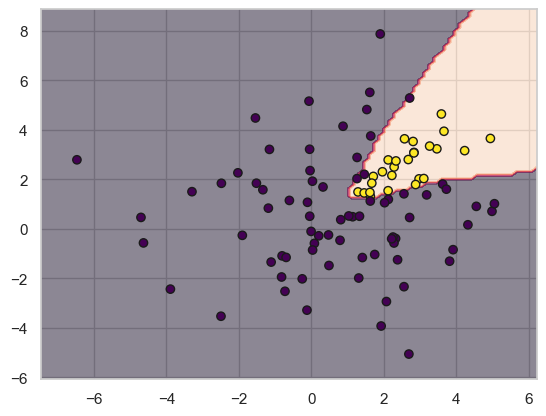

In [50]:
def generalized_cone_kernel(X, Y=None, gamma=1, beta=None, delta=None):
    if Y is None:
        Y = X
    if gamma is None:
        gamma = 1 / X.shape[1]

    X_norms = np.linalg.norm(X, axis=1)
    Y_norms = np.linalg.norm(Y, axis=1)
    norm_grid = np.meshgrid(X_norms, Y_norms)
    sum_norms = norm_grid[0] + norm_grid[1]

    if beta is None:
        beta =  1 / np.std(sum_norms) 
    if delta is None:
        delta = 1 / np.std(sum_norms)

    # alpha = np.exp(-beta * sum_norms).T
    alpha = ((1/(1 + np.exp(beta * (sum_norms - delta)))) * (1/(1 + np.exp(-beta * (sum_norms + delta)))) * (1 + np.exp(-beta * delta))**2).T
    return np.exp(-gamma * (alpha * euclidean_distances(X, Y) + (1 - alpha) * 2 * (1 - cosine_similarity(X, Y))))

clf = SVC(kernel=generalized_cone_kernel, gamma=10)
clf.fit(X_shifted, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X_shifted, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X_shifted[::2, 0], X_shifted[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')

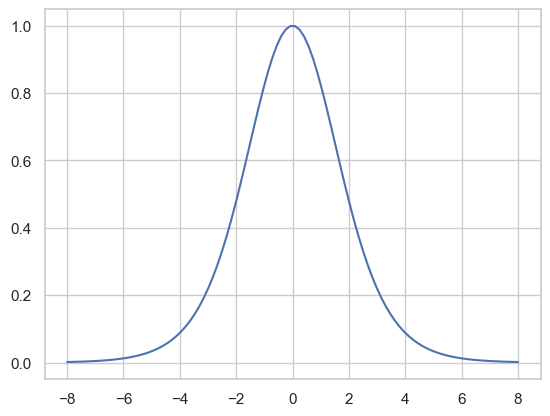

In [36]:
import matplotlib.pyplot as plt

def alpha(x, beta, delta):
    return (1/(1 + np.exp(beta * (x - delta)))) * (1/(1 + np.exp(-beta * (x + delta)))) * (1 + np.exp(-beta * delta))**2

x = np.linspace(-8, 8, 100)

plt.plot(x, alpha(x, 1, 1))